In [1]:
import numpy as np
from numpy.random import default_rng
rng = default_rng(0)
import matplotlib.pyplot as plt

!pip install colorednoise

In [2]:
fs = 1000  # 1 kHz
total_time = 10000  # 10 seconds or 10000 milliseconds

samples = 1 * total_time
t = np.linspace(0, total_time/1000, samples)

In [3]:
import colorednoise as cn
from scipy import signal

beta = 1  # pink noise is 1
noise = cn.powerlaw_psd_gaussian(beta, samples)

print(noise.shape)

(10000,)


In [4]:
from scipy import signal

noise_amp = abs(signal.hilbert(noise))
threshold = np.mean(noise_amp) + (1 * np.std(noise_amp))

1.8804909506820289


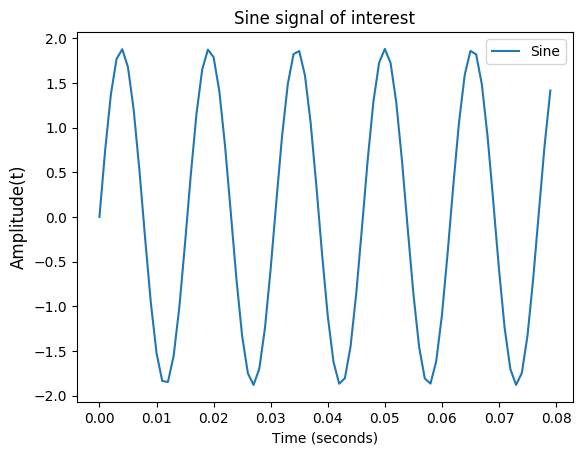

In [5]:
amplitude = threshold
print(amplitude)
frequency = 65  # 65 Hz

sine = amplitude * np.sin(frequency * 2 * np.pi * t)
plt.plot(t[:80], sine[:80], label='Sine')
plt.title('Sine signal of interest')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude(t)', fontsize='large')
# plt.xlim(1,samples)
plt.legend()
plt.show()

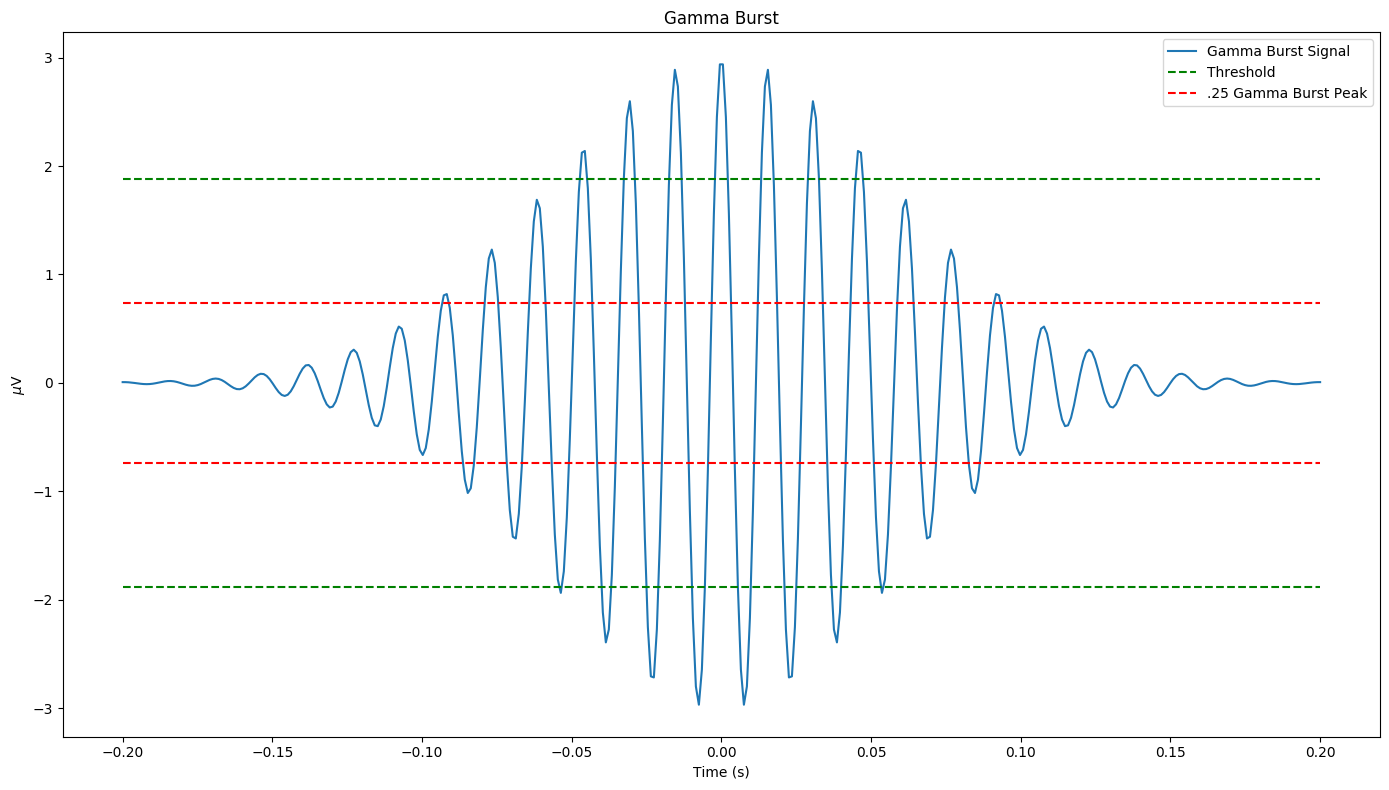

In [6]:
gp_t = np.linspace(-.2, .2, 400)

plt.figure(figsize=(14,8))
yl = 3 * signal.gausspulse(gp_t, fc=65, bw=0.1)  # bw = [.1, .6]
bt = .25 * np.max(yl)
plt.plot(gp_t, yl, label='Gamma Burst Signal')
plt.plot(gp_t, [threshold for _ in range(gp_t.shape[0])], 'g--', label='Threshold')
plt.plot(gp_t, [bt for _ in range(gp_t.shape[0])], 'r--', label='.25 Gamma Burst Peak')
plt.plot(gp_t, [-threshold for _ in range(gp_t.shape[0])], 'g--')
plt.plot(gp_t, [-bt for _ in range(gp_t.shape[0])], 'r--')
plt.title('Gamma Burst')
plt.xlabel('Time (s)')
plt.ylabel(r'$\mu$V')
plt.legend()
plt.tight_layout()
plt.show()

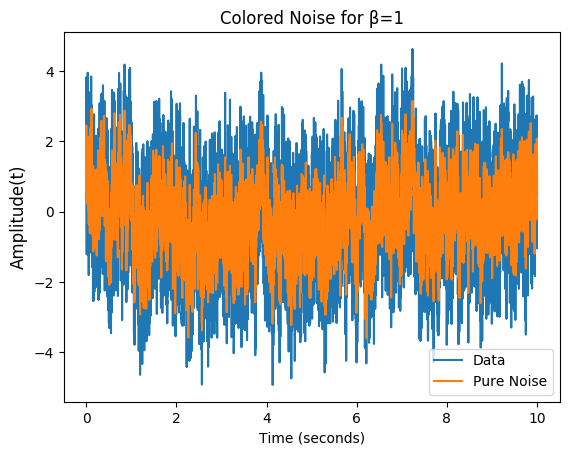

In [7]:
plt.plot(t, noise+sine, label='Data')
plt.plot(t, noise, label='Pure Noise')
plt.title('Colored Noise for β='+str(beta))
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude(t)', fontsize='large')
plt.legend()
plt.show()

In [8]:
FENG_LFP_PATH = '/home/matt/data/InVivoLFPs/FengData/LFP_elec_combine.txt'
FENG_ITN_PATH = '/home/matt/data/InVivoLFPs/FengData/FR_PN_ITN.txt'

from lfp_prediction.data_gathering import TextCollector

frequency_band = (60, 70)

if 'dc' in locals():  # This is done to delete the massive variables and free up some space before attempting to use more
    del dc
dc = TextCollector(FENG_LFP_PATH)
lfp = dc.get_data(column=None)
dc = TextCollector(FENG_ITN_PATH)
itn = dc.get_data(column=2)

del dc

fs = 1000
z, a = signal.butter(4, frequency_band, btype='bandpass', output='ba', fs=fs)
filtered_data = signal.filtfilt(z, a, lfp, axis=0)

LFP_amp = abs(signal.hilbert(filtered_data))
threshold = np.mean(LFP_amp) + (1 * np.std(LFP_amp))

indices = np.argwhere(abs(filtered_data) > threshold)
lfp_mask = np.zeros(filtered_data.shape)
lfp_mask[indices] = 1

change_idxs = np.diff(lfp_mask, axis=0)
ones = np.argwhere(change_idxs == 1)[:,0]
n_ones = np.argwhere(change_idxs == -1)[:,0]
lfp_mask = np.zeros(filtered_data.shape)
lfp_mask[ones] = 1
lfp_mask[n_ones] = -1

gaps = np.diff(ones, axis=0)
n_gaps = np.diff(n_ones, axis=0)

lfp_gap = np.diff(lfp_mask, axis=0)

ones_idxs = np.argwhere(gaps > 28)[:,0]
n_ones_idxs = np.argwhere(n_gaps > 28)[:,0]
lfp_mask_2 = np.zeros(filtered_data.shape)

full_index_list = np.arange(filtered_data.shape[0])

combo_idxs = np.sort(np.concatenate((ones[ones_idxs], n_ones[n_ones_idxs])), axis=0)
combo_idxs = np.insert(combo_idxs, 0, [0])
combo_idxs = np.append(combo_idxs, filtered_data.shape[0]-1)
print(combo_idxs)

# list_of_bursts = np.split(filtered_data[:,0], combo_idxs.astype(int).tolist())

list_of_bursts = []
i = 0
while i < combo_idxs.shape[0]-1:
    list_of_bursts.append(filtered_data[combo_idxs[i]:combo_idxs[i+1],0])
    i += 2


lob = []
for i, l in enumerate(list_of_bursts):
    m = np.max(l)
    if m < threshold:
        continue
    else:
        # print(i, m, threshold)
        qm = .25 * m
        si = np.argmax(l>qm)
        ei = len(l) - np.argmax(l[::-1]>qm)
        if ei - si < 20:
            continue
        lob.append(l[si:ei])

fixed_bursts = []
for l in lob:
    if l.shape[0] < 400:
        pad_needed = 400 - l.shape[0]
        front_pad = int(pad_needed/2)
        back_pad = pad_needed - front_pad
        fixed_bursts.append(np.pad(l, pad_width=(front_pad, back_pad), mode='edge'))
    elif l.shape[0] > 400:
        center_idx = int(l.shape[0] / 2)
        fixed_bursts.append(l[center_idx-200:center_idx+200])
fixed_burst_sizes = np.stack(fixed_bursts)
print(fixed_burst_sizes.shape)

[      0     145     147 ... 2999589 2999590 3000000]
(6285, 400)


In [9]:
sin_len = 400

z, a = signal.butter(4, [60, 70], btype='bandpass', output='ba', fs=fs)

data = []
labels = []
bursts = []
num_samples = 7500

padding_len = 30
padding = np.zeros(padding_len)
for i in range(num_samples):
    bw = rng.uniform(low=0.1, high=0.6)
    bursts.append(np.concatenate((padding, (rng.uniform(low=2.75, high=3.25) * signal.gausspulse(gp_t, fc=65, bw=bw)))))
bursts = np.stack(bursts)
print(bursts.shape)

indices = rng.choice(noise.shape[0] - sin_len, num_samples, replace=False)
inc_sin = rng.choice([0, 1], size=num_samples, replace=True)
inc_bur = rng.choice(np.arange(padding_len), size=num_samples, replace=True)
inc_feng_bur = rng.choice(np.arange(fixed_burst_sizes.shape[0]), size=num_samples, replace=True)
for i, idx in enumerate(indices):
    if inc_sin[i] == 1:
        # data.append(noise[idx:idx+int(sin_len/2)] + sine[idx:idx+int(sin_len/2)])
        # data.append(noise[idx:idx+int(sin_len/2)] + bursts[i, inc_bur[i]:inc_bur[i] + int(sin_len/2)])
        data.append(fixed_burst_sizes[inc_feng_bur[i],:200])

        labels.append(1)
    else:
        filtered_data = signal.filtfilt(z, a, noise[idx:idx+int(sin_len/2)], axis=0)
        data.append(filtered_data)
        labels.append(0)



data = np.stack(data).reshape((num_samples, 1, -1))
labels = np.stack(labels).reshape((num_samples, 1, -1))
print(data.shape)
print(labels.shape)

(7500, 430)
(7500, 1, 200)
(7500, 1, 1)


In [10]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

split_idx = int(.75 * data.shape[0])

print(split_idx)
print(data.shape)
print(labels.shape)

train_data = DataLoader(TensorDataset(torch.Tensor(data[:split_idx, :, :]), torch.Tensor(labels[:split_idx, :, :])), batch_size=batch_size, shuffle=True)
valid_data = DataLoader(TensorDataset(torch.Tensor(data[split_idx:, :, :]), torch.Tensor(labels[split_idx:, :, :])), batch_size=batch_size, shuffle=False)

5625
(7500, 1, 200)
(7500, 1, 1)


<Figure size 1500x1500 with 0 Axes>

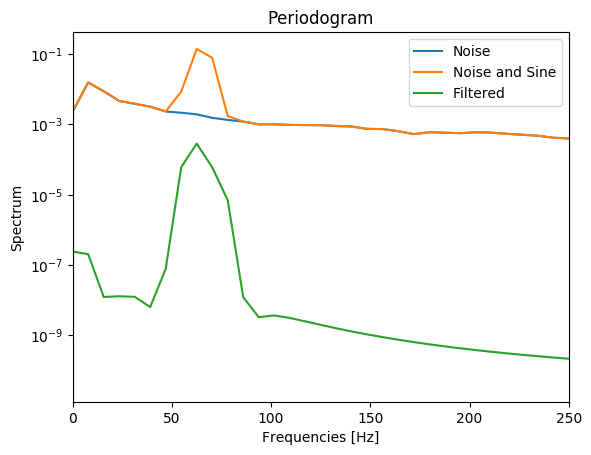

In [11]:
from scipy.signal import welch

plt.figure(figsize=(15, 15))

axs = plt.subplots()

f_n, psd_n = welch(noise, fs=fs, window='hamming', nperseg=128, scaling='density', axis=0)
f_ns, psd_ns = welch(noise+sine, fs=fs, window='hamming', nperseg=128, scaling='density', axis=0)
f_f, psd_f = welch(filtered_data, fs=fs, window='hamming', nperseg=128, scaling='density', axis=0)
plt.semilogy(f_n, psd_n, label='Noise')
plt.semilogy(f_ns, psd_ns, label='Noise and Sine')
plt.semilogy(f_f, psd_f, label='Filtered')
# plt.ylim([1e-3, 1e-1])
plt.xlim([0, 250])
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Spectrum')
plt.title('Periodogram')
plt.legend()
plt.show()

In [12]:
import torch
import torch.nn as nn

class FullyConnected(nn.Module):
    def __init__(self,
                 in_size: int = 200,
                 out_size: int = 200):
        super(FullyConnected, self).__init__()
        self.fcn = nn.Sequential(
            nn.Linear(in_size, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fcn(x)


class LSTM(nn.Module):
    def __init__(self, in_size: int = 1,
                 h_size: int = 200,
                 out_size: int = 200,
                 num_layers: int = 1,
                 batch_first: bool = True,
                 dropout: float = 0.0) -> None:
        super(LSTM, self).__init__()
        self.rnn = nn.LSTM(input_size=in_size,
                           hidden_size=h_size,
                           num_layers=num_layers,
                           batch_first=batch_first,
                           dropout=dropout)
        self.lin = nn.Linear(h_size, out_size)

    def forward(self, x):
        x = torch.transpose(x, 1, 2)  # RNN variants expect (N, L, H)
        x, (_, _) = self.rnn(x)  # Returns (N, L, hidden_size)
        return x[:, -1, :]
        # out = self.lin(x[:, -1, :])  # Feeds hidden stats of last cell to FCN
        # return out

In [13]:
from typing import Optional, Tuple, List
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm


def fit(model: nn.Module,
        training_loader: DataLoader,
        validation_loader: DataLoader,
        epochs: int = 50,
        device: str = 'cpu',
        write_losses: bool = False,
        save_filepath: Optional[str] = None,
        **kwargs) -> Tuple[List, List]:
    """
    Function used to fit the specified model with the provided data
    :param model: neural network pytorch model
    :param training_loader: pytorch dataloader containing the training data
    :param validation_loader: pytorch dataloader containing the validation data
    :param epochs: number of epochs to train
    :param device: which device to train the model on. Should be either "cuda:0" or "cpu"
    :param write_losses: boolean flag as to report losses during training
    :param save_filepath: path to save model, if not specified, no model is saved
    :param kwargs: "optim" optimizer,
                    "loss_function" loss function,
                    "decay_rate" decay rate,
                    "model_save_path" model save path,
                    "loss_save_path" csv save path
    :return: training and validation losses over each epoch
    """
    train_loss_list = []
    val_loss_list = []

    # splitting the dataloaders to generalize code
    data_loaders = {"train": training_loader, "val": validation_loader}
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) if 'optim' not in kwargs else kwargs.get('optim')

    loss_func = nn.MSELoss() if 'loss_function' not in kwargs else kwargs.get('loss_function')

    decay_rate = .99995 if 'decay_rate' not in kwargs else kwargs.get('decay_rate')
    lr_sch = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)

    temp_loss = 100000000000000.0

    """
    You can easily adjust the number of epochs trained here by changing the number in the range
    """
    for epoch in tqdm(range(epochs), position=0, leave=True):
        train_loss = 0.0
        val_loss = 0.0

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            for i, (x, y) in enumerate(data_loaders[phase]):
                x = x.to(device)
                output = model(x)
                y = y.to(device)
                loss = loss_func(torch.squeeze(output), torch.squeeze(y))

                # backprop
                optimizer.zero_grad()
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # calculating total loss
                running_loss += loss.item()

            if phase == 'train':
                train_loss = running_loss
                lr_sch.step()
            else:
                val_loss = running_loss

        # shows total loss
        if epoch % 10 == 0 and write_losses:
            tqdm.write('{} train loss: {.6f} val loss: {.6f}'.format(epoch + 1, train_loss, val_loss))

        # saving best model
        if train_loss < temp_loss and save_filepath:
            torch.save(model, save_filepath)
            temp_loss = train_loss

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)


    return train_loss_list, val_loss_list

In [14]:
import copy

epochs = 50
# model = LSTM()
model = FullyConnected()
model_initial = copy.deepcopy(model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
t_loss, v_loss = fit(model, train_data, valid_data, epochs, device, loss_function=nn.BCELoss())

  0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
test_data = DataLoader(TensorDataset(torch.Tensor(data), torch.Tensor(labels)), batch_size=2048, shuffle=True)

x, y = next(iter(test_data))
model.eval()
x = x.to(device)
output = model(x)
x = x.to("cpu").detach().numpy()
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()

preds = (output>0.5).astype(float)

print(x.shape)
print(y.shape)
print(preds.shape)

(2048, 1, 200)
(2048, 1, 1)
(2048, 1, 1)


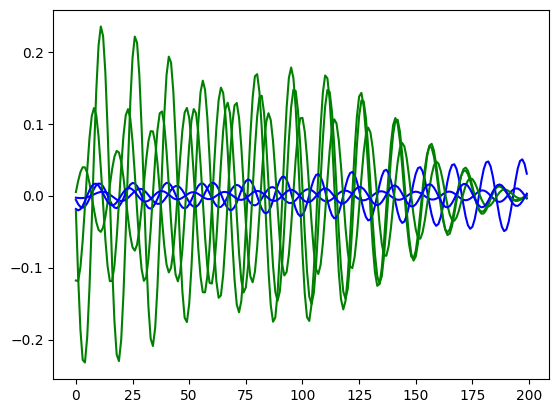

In [16]:
color_list = ['blue' if preds[i,0,0] == 1 else 'green' for i in range(preds.shape[0]) ]

plt.plot(np.arange(200), x[0,0,:], c=color_list[0])
plt.plot(np.arange(200), x[1,0,:], c=color_list[1])
plt.plot(np.arange(200), x[2,0,:], c=color_list[2])
plt.plot(np.arange(200), x[3,0,:], c=color_list[3])
plt.plot(np.arange(200), x[4,0,:], c=color_list[4])
plt.plot(np.arange(200), x[5,0,:], c=color_list[5])
plt.show()

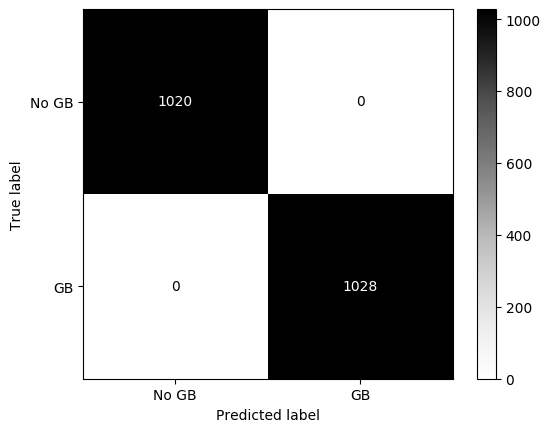

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(np.squeeze(y), np.squeeze(preds), display_labels=['No GB', 'GB'], cmap='Greys')
plt.show()

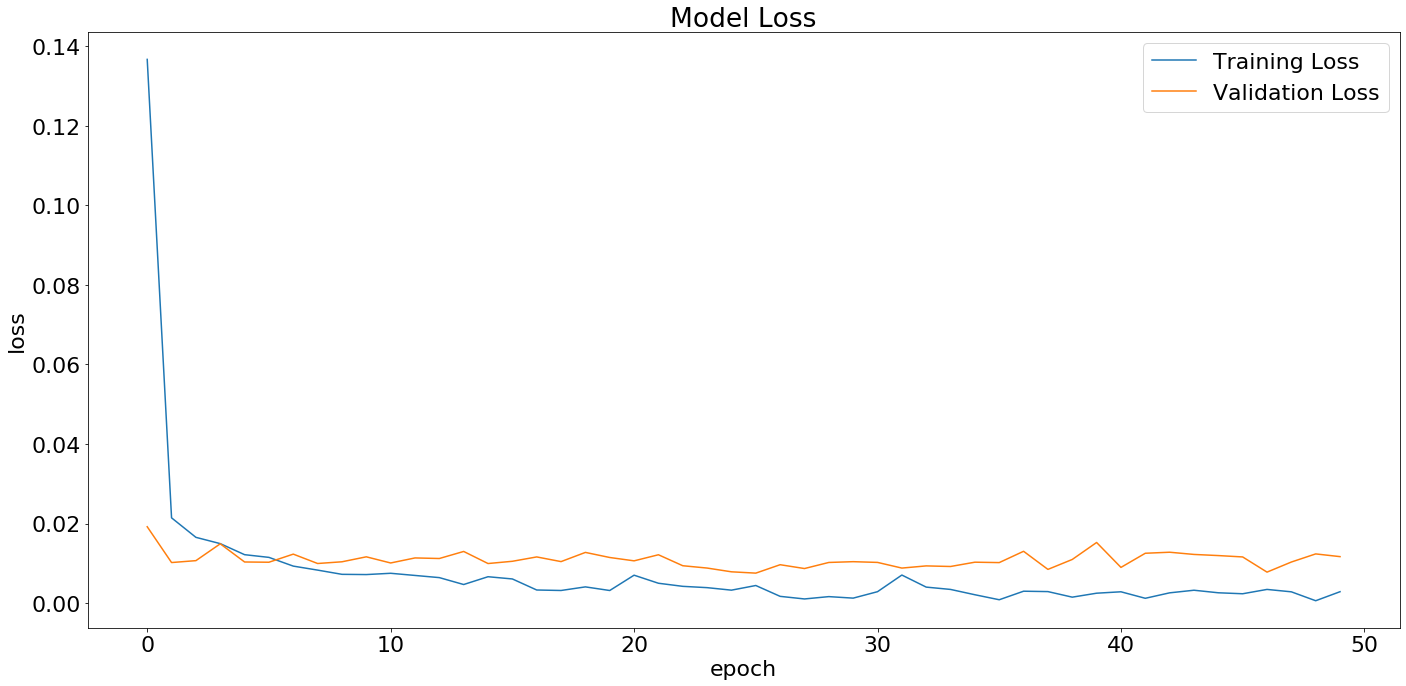

In [18]:
from matplotlib.gridspec import GridSpec
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter

scaled_t_loss = [l/(split_idx/batch_size) for l in t_loss]
scaled_v_loss = [l/((data.shape[0] - split_idx)/batch_size) for l in v_loss]

plt.rcParams['font.size'] = 22

plt.figure(figsize=(20,10))

plt.plot(np.arange(epochs), np.array(scaled_t_loss), label='Training Loss')
plt.plot(np.arange(epochs), np.array(scaled_v_loss), label='Validation Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Model Loss')
plt.legend(loc='best')
plt.tight_layout()
plt.show()